# Trade Shows in the World: Network Analysis

### Part 1: Cleaning Data and Building Graph

In [1]:
import pandas as pd
from unidecode import unidecode
import string

path = 'C:/Users/2093/Desktop/Data Center/03. Data/10. trade_shows/'

# Exhibitor data
exhr = pd.read_excel(path + 'Exhibitor_List_0117.xlsx',
                     parse_cols='B,D:H,O,S',
                     parse_date=['EXHIBITION_START_DATE', 'EXHIBITION_END_DATE'])
exhr.columns = ['show', 'start_date', 'end_date', 'exhr', 'exhr_ctry', 'exhr_ctry_code', 'category',
                'show_id']
exhr['exhr'] = exhr['exhr'].astype(str)
exhr['show_id'] = exhr['show_id'].astype(int)

# Clean exhibitor country and company name columns
exhr['exhr_ctry'] = exhr['exhr_ctry'].str.lower().str.strip().str.replace(' ', '').replace({
    'cacada': 'canada',
    'ivorycoast': "coted'ivoire",
    'southkorea': 'korea',
    'russianfederation': 'russia',
    'serbiaandmontenegro': 'serbia'
    })
exhr['exhr_conv'] = exhr['exhr'].str.lower().str.strip().apply(lambda x: unidecode(x)).apply(
    lambda x: x.translate(str.maketrans({key: None for key in string.punctuation}))).str.replace(
    r'\s+', r' ')
pd.Series(' '.join(exhr['exhr_conv']).split(' ')).value_counts().head(20)

exhr = exhr[exhr['start_date'].dt.year == 2016]

In [2]:
# All trade shows in 2016 that have exhibitor data, with dates
shows_16 = exhr[['show_id', 'start_date']].drop_duplicates().sort_values(
    'start_date').reset_index(drop=True)

# Build adjacency matrix
adj = pd.DataFrame([(x, y) for x in shows_16['show_id'] for y in shows_16['show_id']
                    if shows_16.loc[shows_16['show_id'] == x, 'start_date'].values
                    < shows_16.loc[shows_16['show_id'] == y, 'start_date'].values])
adj.columns = ['former', 'latter']
adj['weight'] = 0
for lab, row in adj.iterrows():
    adj.loc[lab, 'weight'] = (
        exhr[(exhr['show_id'] == row['former']) | (exhr['show_id'] == row['latter'])]
        .groupby('exhr')['show_id'].count() >= 2
    ).sum()

# Remove rows with zero weight
adj = adj[adj['weight'] != 0]

In [3]:
import networkx as nx

G = nx.from_pandas_dataframe(adj, source='former', target='latter', edge_attr='weight',
                             create_using=nx.DiGraph())

Implementing the generalized degree centrality proposed by Opsahl et al. (2010):  
  
$$k^\alpha = k(i) \times \left(\frac{s(i)}{k(i)}\right)^\alpha$$
  
where $k(i) = \sum_{j}^{N}x_{ij}$ (Freeman, 1978) and $s(i) = \sum_{j}^{N}w_{ij}$ (Barrat et al., 2004).

In [4]:
def generalized_degree_centrality(G, alpha=0.5):
    """Return a dictionary of generalized degree centralities.
    
    Nodes of input graph must have a `weight` attribute.
    """
    ds = nx.degree(G)
    dws = nx.degree(G, weight='weight')
    gdc = {k: d * (dw/d)**alpha for k, d, dw in zip(ds.keys(), ds.values(), dws.values())}
    return gdc

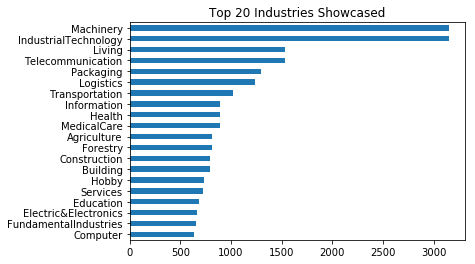

Removed node 1122.
Removed node 2294.


In [5]:
import re
import matplotlib.pyplot as plt

# Trade show data
shows = pd.read_excel(path + 'Jetro_Expo_List0119.xls', index_col=0,
                      parse_cols='A,B,D:F,H,P,Q',
                      parse_date=['exhibition_start_date', 'exhibition_end_date'])
shows.index.name = 'show_id'
shows.columns = ['show', 'start_date', 'end_date', 'show_ctry', 'show_ctry_code', 'industry', 'n_com']

# Top 20 industries showcased
ind_cnt = pd.Series(re.split(r'[/;,]', '/'.join(
    shows['industry'].str.replace(r'\(.*?\)', r'')))).value_counts().head(20)[-1::-1]
ind_cnt.plot(kind='barh')
plt.title('Top 20 Industries Showcased')
plt.show()

shows['industry'] = shows['industry'].str.replace(r'\(.*?\)', r'').str.split(r'[/;,]').str.join('|')
shows['istw'] = shows['show_ctry_code'] == 'TW'
shows_16 = shows[shows['start_date'].dt.year == 2016]

# Build trade show metadata
ds = nx.degree(G)
gdcs = generalized_degree_centrality(G, alpha=0.2)
for n, d in G.nodes(data=True):
    if n in shows_16.index:
        row = shows_16.loc[n]
        d.update({
            'name': row['show'],
            'start': row['start_date'],
            'end': row['end_date'],
            'ctry': row['show_ctry'],
            'istw': row['istw'],
            'n_com': row['n_com'],
            'ind': row['industry'],
            'degree': ds[n],
            'gdc': gdcs[n]
        })
    else:
        G.remove_node(n)
        print('Removed node {}.'.format(n))

### Part 2: Characterizing Network

Number of nodes: 133
Number of edges: 7076


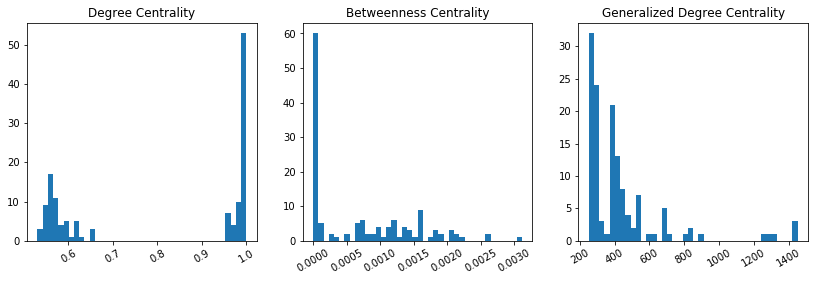

In [6]:
print('Number of nodes: {0}\nNumber of edges: {1}'.format(len(G.nodes()), len(G.edges())))

plt.figure(figsize=(14, 4))
plt.subplot(131)
plt.hist(list(nx.degree_centrality(G).values()), bins=40)
plt.title('Degree Centrality')
plt.xticks(rotation=30)
plt.subplot(132)
plt.hist(list(nx.betweenness_centrality(G).values()), bins=40)
plt.title('Betweenness Centrality')
plt.xticks(rotation=30)
plt.subplot(133)
plt.hist(list(generalized_degree_centrality(G).values()), bins=40)
plt.title('Generalized Degree Centrality')
plt.xticks(rotation=30)
plt.show()

#### Top 10 Most Important Trade Shows

In [7]:
import operator

gdcs = generalized_degree_centrality(G)
top_gdcs = sorted(gdcs.items(), key=operator.itemgetter(1))[-10:][-1::-1]
top_df = pd.DataFrame(top_gdcs).set_index(0)
top_df.columns = ['gdc']
top_df.index.name = 'show_id'
pd.concat([top_df, shows_16], join='inner', axis=1).loc[
    :, ['show', 'show_ctry', 'start_date', 'end_date', 'gdc']].sort_values('gdc', ascending=False)

,show,show_ctry,start_date,end_date,gdc
show_id,,,,,
2136,electronica 2016,Germany,2016-11-08,2016-11-11,1452.725026
1853,3rd Next Generation Agriculture Expo Tokyo,Japan,2016-10-12,2016-10-14,1425.123153
1859,13th International Flower Expo Tokyo (IFEX),Japan,2016-10-12,2016-10-14,1425.123153
2106,International Manufacturing Technology Show(IM...,United States,2016-09-12,2016-09-17,1322.447731
2221,EUROBIKE 2016- International Bicycle Trade Exh...,Germany,2016-08-31,2016-09-04,1289.292829
829,INDUSTRIE_Paris,France,2016-04-04,2016-04-08,1263.751558
2130,K 2016 - The World's NO.1 Trade Fair for Plast...,Germany,2016-10-19,2016-10-26,901.804857
2137,GITEX Technology Week 2016,United Arab Emirates,2016-10-16,2016-10-20,845.290483
2181,IBC Exhibition (IBC 2016),Netherlands,2016-09-09,2016-09-13,835.157470


#### Neighbors of FOOD TAIPEI

C:\Users\2093\AppData\Local\Continuum\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
C:\Users\2093\AppData\Local\Continuum\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
C:\Users\2093\AppData\Local\Continuum\Anaconda3\lib\site-packages\matplotlib\__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
C:\Users\2093\AppData\Local\Continuum\Anaconda3\lib\site-packages\matplotlib\rcsetup.py:152: UserWarning: axes.hold is dep

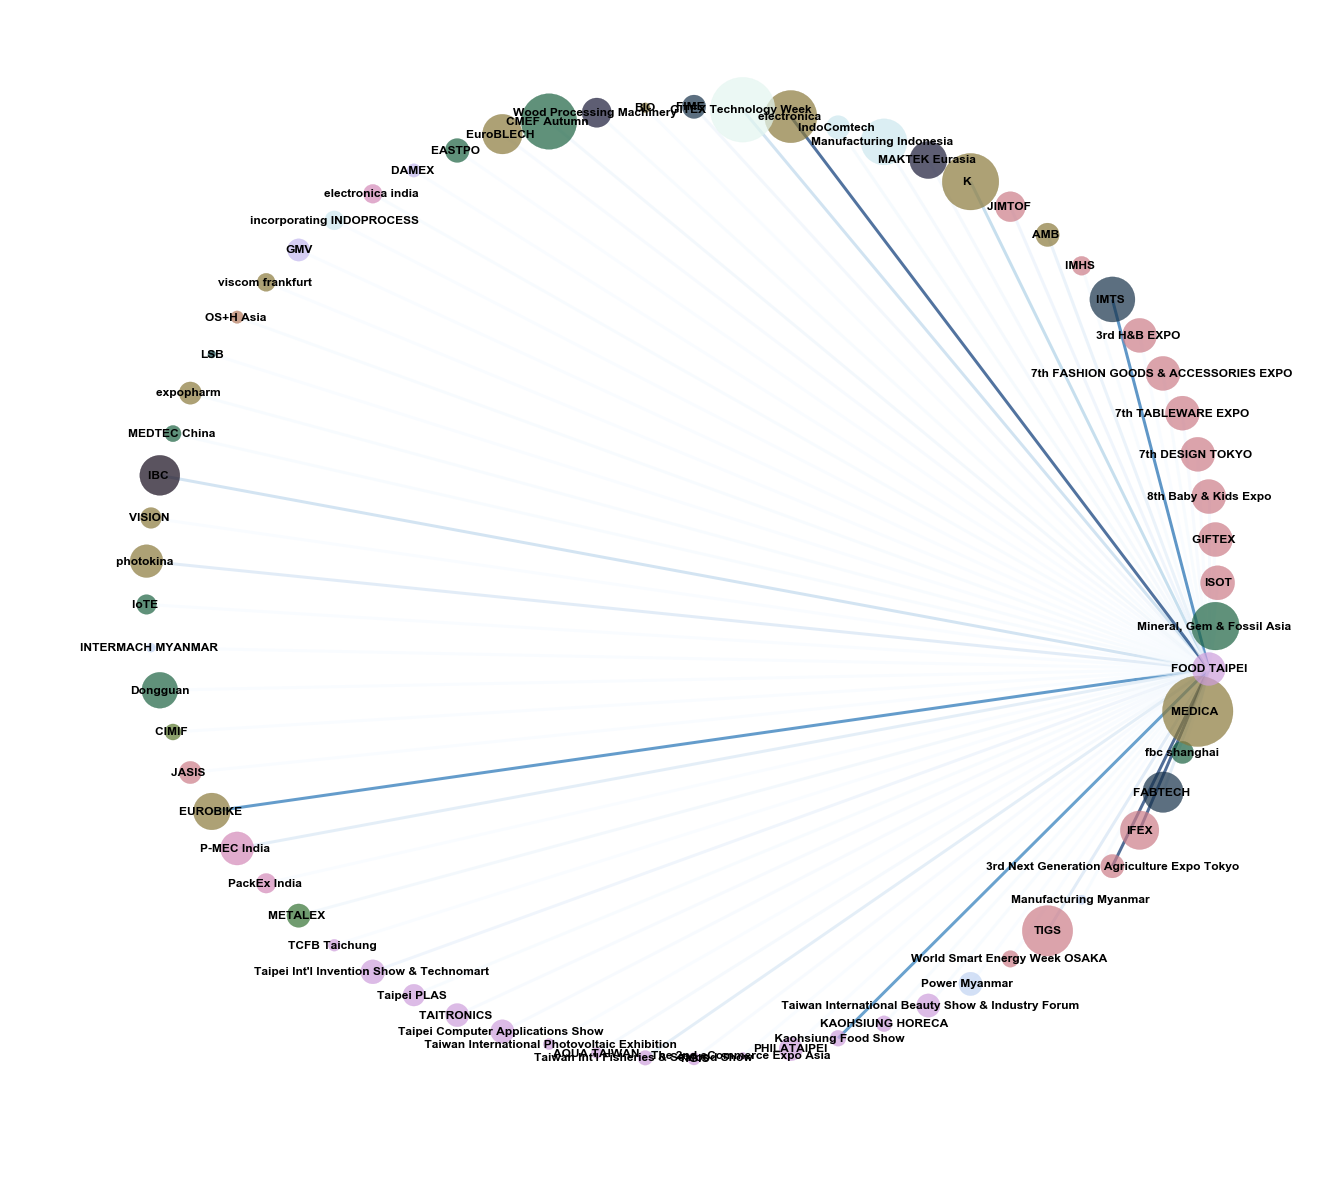

In [8]:
import seaborn as sns
import numpy as np
import math

G_food = G.subgraph({1493} | set(G.neighbors(1493)))

clrs = sns.color_palette('cubehelix', 16)
clrs = [(int(255*x), int(255*y), int(255*z)) for x, y, z in clrs]
clr_map = dict(zip(set([d['ctry'] for n, d in G_food.nodes(data=True)]),
                   map(lambda x: '#%02x%02x%02x' % x, clrs)))

n_com_median = np.nanmedian(np.array([d['n_com'] for n, d in G_food.nodes(data=True)]))
labels = {n: re.sub('2016|2017', '', re.search(r'\(([^\(\)]*)\)', d['name']).group(1))
          if re.search(r'\(([^\(\)]*)\)', d['name'])
          else re.sub(r'-[A-Z]{1}[^A-Z]{1}.*|- [A-Z]{1}.*', '', re.sub('2016|2017', '', d['name']))
          for n, d in G_food.nodes(data=True)}

plt.figure(figsize=(18, 16))
nx.draw_circular(G_food,
                 arrows=False,
                 with_labels=True,
                 edgelist=[(n1, n2) for n1, n2, d in G_food.edges(data=True) if n1 == 1493 or n2 == 1493],
                 node_size=[d['n_com'] if not math.isnan(d['n_com']) else n_com_median for n, d in G_food.nodes(data=True)],
                 node_color=list(pd.Series([d['ctry'] for n, d in G_food.nodes(data=True)]).map(clr_map)),
                 alpha=0.7,
                 width=3,
                 edge_color=[d['weight'] for n1, n2, d in G_food.edges(data=True) if n1 == 1493 or n2 == 1493],
                 edge_cmap=plt.get_cmap('Blues'),
                 labels=labels,
                 font_size=12,
                 font_color='black',
                 font_weight='bold',
                 )
plt.savefig('food_neighbors.jpg', dpi=300)
plt.show()

In [9]:
import nxviz as nv
import matplotlib.pyplot as plt

m = nv.MatrixPlot(G)
m.draw()
plt.savefig('matrix_plot.jpg', dpi=300)

a = nv.ArcPlot(G, edge_width='weight', node_color='istw', node_size='n_com')
a.draw()
plt.savefig('arc_plot.jpg', dpi=300)

c = nv.CircosPlot(G, edge_width='weight', node_color='istw', node_size='n_com')
c.draw()
# labels = {}
# labels.update({n: d['name'] for n, d in D.nodes(data=True) if d['istw']})
# pos = nx.nx_pydot.graphviz_layout(D, prog='circo')
# nx.draw_networkx_labels(D, pos, labels, font_size=16)
plt.savefig('circos_plot.jpg', dpi=300)